In [2]:
import pickle
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

%matplotlib inline

In [3]:
with open('lsa_cv.pkl','rb') as file:
    lsa_cv = pickle.load(file)

In [4]:
with open('nmf_cv.pkl','rb') as file:
    nmf_cv = pickle.load(file)

In [6]:
# takes out Chinese, Japanese, and Korean characters with unicode data
def emoticon_tokenize(s):
    token_pattern = r'(?<=^|(?<=\b))[\w\#]\w+\b'
    emoji_regex = re.compile(r'[\u263a-\U0001f645]')
    token_regex = re.compile(token_pattern, flags=re.ASCII)
    emoticons = emoji_regex.findall(s)
    parsed_emoticons=[] 
    for e in emoticons: 
        try: 
            if unicodedata.name(e)[:3]!='CJK' and unicodedata.name(e)[:8]!='HIRAGANA' and unicodedata.name(e)[:8]!='KATAKANA':
                parsed_emoticons.append(e)
        except: 
            pass
    word_list = token_regex.findall(s)
    return word_list + parsed_emoticons

In [7]:
with open('cv.pkl','rb') as file:
    cv = pickle.load(file)

In [8]:
f = open('updateddataframe.pkl','rb')
df = pickle.load(f)

In [9]:
df.head(5)

,created_at,location,screen_name,source,text,cleaned_text
0,Fri May 18 23:32:39 +0000 2018,Midwest USA - Blog:,SueSpenceDaniel,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Royal Wedding countdown... can't wait! #RoyalW...,royal wedding countdown cant wait #royalwed
1,Fri May 18 23:32:40 +0000 2018,None,AsliAyan1,"<a href=""http://twitter.com/download/iphone"" r...",İngiliz kraliyetini yıllardır çok severek taki...,i̇ngiliz kraliyetini yıllardır çok severek tak...
2,Fri May 18 23:32:41 +0000 2018,"Nairobi, Kenya",VictorMochere,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",DONATE:\n\nAs a football fan and an adventurer...,donateas a football fan and an adventurer it h...
3,Fri May 18 23:32:41 +0000 2018,Curitiba,Nath_Maia,"<a href=""http://twitter.com/download/android"" ...",Só queria dizer que se eu casasse com o Princi...,só queria dizer que se eu casasse com o princi...
4,Fri May 18 23:32:44 +0000 2018,Lanarkshire Sco,weemazsmith,"<a href=""http://twitter.com/download/android"" ...",What am I going to do ! My fav prince is getti...,what am i going to do my fav prince is gettin...


In [10]:
def one_tweet_clean(tweet):
    punctuations = '''!()-[]{};:'"\,<>./?$%^&*_~'''
    new_doc = re.sub(r'http\S+', '', tweet)
    new_doc = html.unescape(new_doc)
    new_doc = new_doc.replace("\n", "")
    new_doc = new_doc.replace("\\","")
    new_doc = new_doc.replace("@Suits_USA","Suits_USA")
    new_doc = new_doc.replace("@RoyalFamily","RoyalFamily")
    new_doc = new_doc.replace("@BishopCurry","BishopCurry")
    new_doc = new_doc.replace("@KensingtonRoyal","KensingtonRoyal")
    new_doc = new_doc.lower()
    new_doc = re.sub(r'@\w+','',new_doc)
    new_doc = re.sub(r'[0-9]', '',new_doc)
    new_doc = stemmer.stem(new_doc)
    for punc in punctuations:
        new_doc = new_doc.replace(punc, "")
    if new_doc in stopwords:
        return None
    return new_doc

In [11]:
# There is one empty text
df[df['cleaned_text'].isnull()]

,created_at,location,screen_name,source,text,cleaned_text
345207,Sat May 19 12:54:04 +0000 2018,"Luton, England",JeorjahEllauize,"<a href=""http://twitter.com/download/iphone"" r...",Same!\nhttps://t.co/0zIRs8AEJz,None


In [12]:
# Drop this row
df.dropna(subset=['cleaned_text'],inplace=True)

In [13]:
# use nmf model for the word vector and impose it on the original dataframe
word_vector = cv.transform(df['cleaned_text'].values)
nmf_topic_vectors = nmf_cv.transform(word_vector)

## Hard Classification

In [14]:
# find the index of the topic with largest vector
hard_topic = np.argmax(nmf_topic_vectors,axis=1)

# hard encode the topic
df_hard_topic=pd.get_dummies(hard_topic)

# combine the two dataframes
df_hard_class = pd.concat([df.reset_index(), df_hard_topic],axis=1)

# drop some columns
df_hard_class.drop(['index'],axis=1, inplace=True)

## Soft Classification

In [15]:
# adding column vecs for the soft classification
df['vecs'] = nmf_topic_vectors.tolist()

# Create a Numpy array of the document vectors
df_np_vecs = np.zeros((len(df),5))
for i, vec in enumerate(df.vecs):
    df_np_vecs[i, :] = vec

# Adding the numpy array (vectors) to the original dataframe
df_full = pd.concat([df.reset_index(), pd.DataFrame(df_np_vecs)], axis=1)

## Drop some columns
df_full.drop(['index', 'vecs'],axis=1, inplace=True)

In [15]:
# pickle the full dataframe
df_full.to_pickle('dataframe_with_vectors.pkl')

In [155]:
df_full.shape

(899933, 11)

## Daily Analysis - Hard Classification

In [ ]:
# change "created_at" to a datetime format
df_hard_class_dt = df_hard_class.copy()
df_hard_class_dt['time']=pd.to_datetime(df["created_at"])
df_hard_class_dt.drop(columns = 'created_at', inplace=True)

In [137]:
# pickle the hard classification
df_hard_class_dt.to_pickle('hard_class.pkl')

In [59]:
with open('hard_class.pkl','rb') as file:
    df_hard_class_dt = pickle.load(file)

In [187]:
# remove data generated on the 18th and the 22nd by creating a mask
mask = (df_hard_class_dt['time'].dt.day==22) | (df_hard_class_dt['time'].dt.day==18)

# create a new dataframe
df_hard_class_days = df_hard_class_dt[~mask]

In [190]:
df_hard_class_days.tail(5)

,location,screen_name,source,text,cleaned_text,0,1,2,3,4,time
896276,None,lacelioness,"<a href=""http://twitter.com/download/android"" ...",@MartinezPerspec I saw your article that refer...,i saw your article that referenced bbc claimi...,0,1,0,0,0,2018-05-21 23:59:55
896277,United States,OlgaCollette,"<a href=""http://twitter.com/download/iphone"" r...",Family https://t.co/0KXrazZMpY,family,0,0,0,1,0,2018-05-21 23:59:55
896278,"Birthplace of Blues, BBQ",cookiebottom25,"<a href=""http://twitter.com/download/iphone"" r...",My favorite photo hands down...Look at future ...,my favorite photo hands downlook at future kin...,0,0,0,0,1,2018-05-21 23:59:56
896279,Feelsville,simplycerulean_,"<a href=""http://twitter.com/download/iphone"" r...",I live https://t.co/XtBjUJwQo8,i live,0,0,0,1,0,2018-05-21 23:59:56
896280,San Angel Inn México DF,TvsEspectaculos,"<a href=""https://studio.twitter.com"" rel=""nofo...",La actriz #MeghanMarkle después de 5 temporada...,la actriz #meghanmarkle después de temporadas...,0,0,1,0,0,2018-05-21 23:59:58


In [200]:
def day_byhour(day,starthour, duration=3, df=df_hard_class_days):
    df_hour = df.loc[((df['time'].dt.day==day) & (starthour<=df['time'].dt.hour) 
                                  &(df['time'].dt.hour<(starthour+duration))), 
                                 [0,1,2,3,4]].sum(axis=0)
    return pd.DataFrame(df_hour, columns=['{}-{}'.format(day,starthour)])

In [201]:
def hourblock(df, duration):
    all_df = []
    for day in [19,20,21]:
        for hour in range(0,24,duration):
            all_df.append(day_byhour(day, hour, duration, df))
    hourly_topic = pd.concat(all_df, axis=1)
    return hourly_topic

In [202]:
df_daybyhour_analysis = hourblock(df_hard_class_days, 3)

In [206]:
df_daybyhour_analysis

,19-0,19-03,19-06,19-9,19-12,19-15,19-18,19-21,20-0,20-3,...,20-18,20-21,21-0,21-3,21-6,21-9,21-12,21-15,21-18,21-21
0,5083,6711,29852,68659,41064,34196,32206,23829,17470,11850,...,8470,5786,3945,3180,4175,4840,7451,6622,4737,3041
1,1728,2213,14845,93369,26703,15478,13861,10283,7081,4760,...,3177,2199,1540,1000,1036,1201,2388,2233,1432,950
2,1003,1293,7453,12061,6999,5435,5521,4044,2879,1946,...,1475,1044,683,518,663,807,1467,1593,986,555
3,1448,1739,8216,13524,7414,5860,5507,4634,3293,2275,...,1667,1160,758,570,801,1020,1736,1652,1015,681
4,1433,1894,8862,24205,17305,15144,14218,11782,8534,6218,...,4641,3238,2106,1512,1715,1801,3299,3207,2057,1349


In [208]:
# rename the column names so graphs will show in chronological order
df_daybyhour_analysis.rename(columns = {'19-3':'19-03', '19-6':'19-06','19-9':'19-09',
                                        '20-3':'20-03', '20-6':'20-06','20-9':'20-09',
                                        '21-3':'21-03', '21-6':'21-06','21-9':'21-09'},inplace=True)

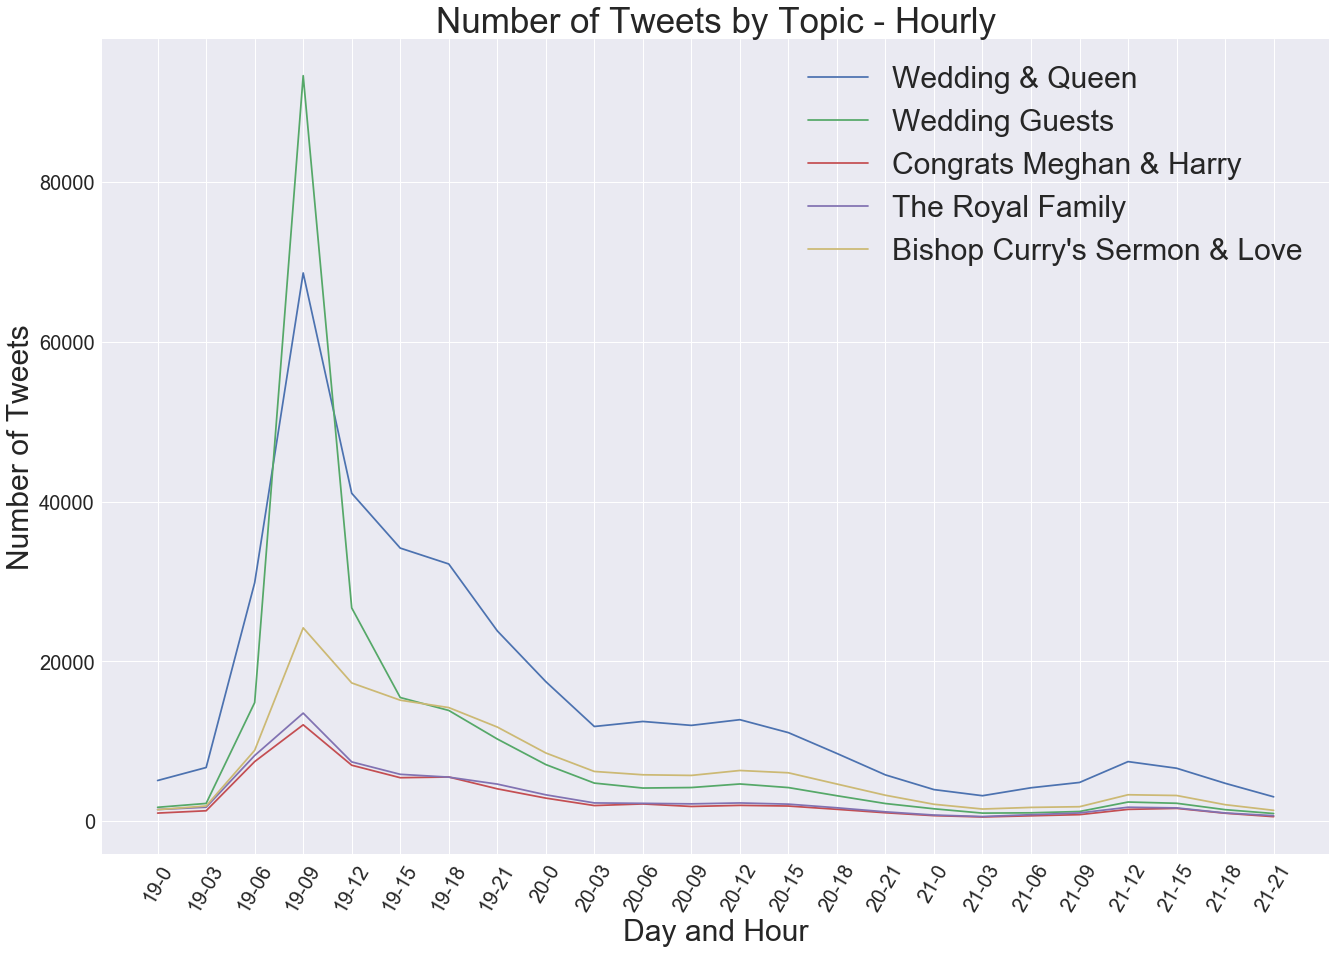

In [217]:
plt.figure(figsize=(22,15))
plt.title('Number of Tweets by Topic - Hourly', fontsize=35)
plt.plot(df_daybyhour_analysis.columns,df_daybyhour_analysis.iloc[0], label='Wedding & Queen')
plt.plot(df_daybyhour_analysis.columns,df_daybyhour_analysis.iloc[1], label='Wedding Guests')
plt.plot(df_daybyhour_analysis.columns,df_daybyhour_analysis.iloc[2], label='Congrats Meghan & Harry')
plt.plot(df_daybyhour_analysis.columns,df_daybyhour_analysis.iloc[3], label='The Royal Family')
plt.plot(df_daybyhour_analysis.columns,df_daybyhour_analysis.iloc[4], label="Bishop Curry's Sermon & Love")
plt.legend(loc='upper right',fontsize=30)
plt.xticks(fontsize=20, rotation=60)
plt.yticks(fontsize=20)
plt.xlabel('Day and Hour',fontsize=30)
plt.ylabel('Number of Tweets',fontsize=30)
plt.savefig('number of tweets by topic - hourly.png', bbox_inches='tight');

## Daily Analysis - Soft Prediction

In [218]:
with open('dataframe_with_vectors','rb') as file:
    full_df = pickle.load(file)

In [219]:
full_df.head(5)

,created_at,location,screen_name,source,text,cleaned_text,0,1,2,3,4
0,Fri May 18 23:32:39 +0000 2018,Midwest USA - Blog:,SueSpenceDaniel,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Royal Wedding countdown... can't wait! #RoyalW...,royal wedding countdown cant wait #royalwed,0.000000,0.045445,0.000000,0.087878,0.000000
1,Fri May 18 23:32:40 +0000 2018,None,AsliAyan1,"<a href=""http://twitter.com/download/iphone"" r...",İngiliz kraliyetini yıllardır çok severek taki...,i̇ngiliz kraliyetini yıllardır çok severek tak...,0.001949,0.000000,0.000741,0.001475,0.060942
2,Fri May 18 23:32:41 +0000 2018,"Nairobi, Kenya",VictorMochere,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",DONATE:\n\nAs a football fan and an adventurer...,donateas a football fan and an adventurer it h...,0.001184,0.001197,0.000759,0.001882,0.002058
3,Fri May 18 23:32:41 +0000 2018,Curitiba,Nath_Maia,"<a href=""http://twitter.com/download/android"" ...",Só queria dizer que se eu casasse com o Princi...,só queria dizer que se eu casasse com o princi...,0.000000,0.047126,0.000000,0.000000,0.000000
4,Fri May 18 23:32:44 +0000 2018,Lanarkshire Sco,weemazsmith,"<a href=""http://twitter.com/download/android"" ...",What am I going to do ! My fav prince is getti...,what am i going to do my fav prince is gettin...,0.041590,0.000000,0.020038,0.003388,0.004816


In [220]:
# change "created_at" to a datetime format
df_soft_class_dt = full_df.copy()

In [221]:
df_soft_class_dt['time']=pd.to_datetime(full_df["created_at"])

In [ ]:
df_soft_class_dt.drop(columns = 'created_at', inplace=True)

In [225]:
# remove data generated on the 18th and the 22nd by creating a mask
mask = (df_soft_class_dt['time'].dt.day==22) | (df_soft_class_dt['time'].dt.day==18)

full_df_days = df_soft_class_dt[~mask]

In [226]:
def day_byhourper(day,starthour, duration=3, df=full_df_days):
    df_hour = df.loc[((df['time'].dt.day==day) & (starthour<=df['time'].dt.hour) 
                                  &(df['time'].dt.hour<(starthour+duration))), 
                                 [0,1,2,3,4]].mean(axis=0)
    return pd.DataFrame(df_hour, columns=['{}-{}'.format(day,starthour)])

In [229]:
def hourblockper(df, duration):
    all_dfper = []
    for day in [19,20,21]:
        for hour in range(0,24,duration):
            all_dfper.append(day_byhourper(day, hour, duration, df))
    hourly_topicper = pd.concat(all_dfper, axis=1)
    return hourly_topicper

In [230]:
df_daybyhourper_analysis = hourblockper(full_df_days, 3)

In [231]:
df_daybyhourper_analysis

,19-0,19-3,19-6,19-9,19-12,19-15,19-18,19-21,20-0,20-3,...,20-18,20-21,21-0,21-3,21-6,21-9,21-12,21-15,21-18,21-21
0,0.021714,0.022542,0.021167,0.013102,0.013298,0.012667,0.013157,0.012560,0.012452,0.011655,...,0.012957,0.012813,0.012377,0.014124,0.018122,0.018773,0.015634,0.015622,0.016841,0.015701
1,0.008011,0.008384,0.010980,0.020694,0.010743,0.006079,0.005108,0.004989,0.004427,0.004207,...,0.003820,0.003600,0.003725,0.003917,0.003905,0.003741,0.002643,0.003077,0.003687,0.004006
2,0.008032,0.008721,0.010999,0.005978,0.005800,0.005177,0.005195,0.005018,0.004760,0.004752,...,0.004665,0.004722,0.005053,0.004610,0.006275,0.006219,0.005812,0.007793,0.006508,0.005941
3,0.010758,0.010658,0.010275,0.004971,0.004792,0.004769,0.004540,0.005072,0.004699,0.004670,...,0.004853,0.005375,0.004683,0.005066,0.006400,0.007535,0.006339,0.007312,0.006269,0.006633
4,0.005291,0.006279,0.006143,0.005771,0.006677,0.006405,0.005630,0.005922,0.005360,0.005289,...,0.005252,0.005429,0.005126,0.005352,0.005964,0.005123,0.005307,0.005341,0.005631,0.005395


## KMeans to find the cluster mean

In [14]:
from sklearn.cluster import KMeans

In [55]:
km = KMeans(n_clusters=4)
clusts = km.fit_predict(nmf_topic_vectors)

In [57]:
cluster_vecs = km.cluster_centers_

In [60]:
cluster_vecs

array([[0.02421133, 0.00891434, 0.08492647, 0.01415451, 0.00840535],
       [0.0003644 , 0.00041979, 0.00114849, 0.00332251, 0.0094482 ],
       [0.00094302, 0.04736651, 0.00402245, 0.00627455, 0.00193653],
       [0.03986649, 0.00045574, 0.00190714, 0.00701116, 0.00268883]])

In [61]:
np.unique(clusts, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([ 43697, 402823, 168265, 285148]))

In [62]:
clusts.shape

(899933,)

In [63]:
clusts[:10]

array([2, 1, 1, 2, 3, 3, 3, 3, 3, 1], dtype=int32)

## KMeans: find number of clusters using inertia

In [15]:
# compute inertia (SSE) over multiple values of k and try to find the "elbow" point
SSE = []
for k in range(2,20):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(nmf_topic_vectors)
    SSE.append(km.inertia_)

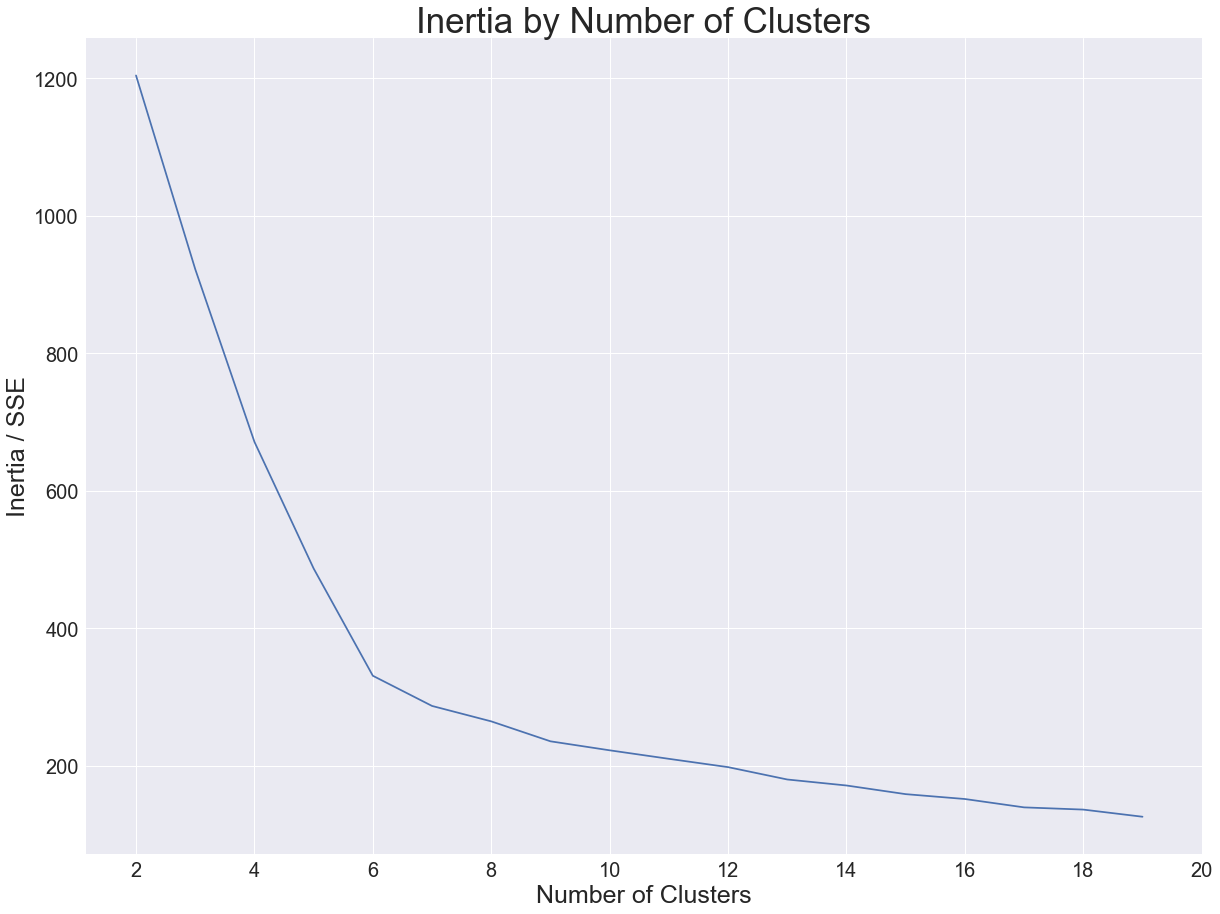

In [359]:
# plot the inertia and visualize the elbow point
plt.figure(figsize=(20,15))
plt.title('Inertia by Number of Clusters',fontsize=35)
k_clusters = range(2,20)
plt.plot(k_clusters, SSE)
plt.xlabel('Number of Clusters',fontsize=25)
plt.ylabel('Inertia / SSE', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(np.arange(2, 21, 2.0))
plt.savefig('Inertia by Number of Clusters.png', bbox_inches='tight');

In [37]:
# try cluster = 6, seems like the most reasonable number of clusters
estimator = KMeans(n_clusters=6)
clusts = estimator.fit_predict(nmf_topic_vectors)

In [38]:
# find the vectors for these six clusters
cluster_vecs = estimator.cluster_centers_

In [78]:
cluster_vecs

array([[0.00035107, 0.00039923, 0.00105344, 0.001678  , 0.00067067],
       [0.03980876, 0.00044733, 0.00189892, 0.00307073, 0.00172182],
       [0.02506905, 0.00910026, 0.08698201, 0.01056108, 0.00650339],
       [0.00091217, 0.04736922, 0.00414438, 0.00306557, 0.00142746],
       [0.02101976, 0.01138668, 0.00645394, 0.09294535, 0.00574564],
       [0.00270382, 0.00134328, 0.00269168, 0.00253291, 0.05212257]])

In [39]:
# find the number of tweets (documents) that belong to each of the cluster
np.unique(clusts, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([327497, 268449,  40159, 161095,  27207,  75526]))

In [57]:
df_cluster = pd.DataFrame(clusts, columns=['cluster'])

In [75]:
df_full_cluster = df_hard_class_dt.join(df_cluster)

In [76]:
df_full_cluster

,location,screen_name,source,text,cleaned_text,0,1,2,3,4,time,cluster
0,Midwest USA - Blog:,SueSpenceDaniel,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Royal Wedding countdown... can't wait! #RoyalW...,royal wedding countdown cant wait #royalwed,0,0,0,1,0,2018-05-18 23:32:39,4
1,None,AsliAyan1,"<a href=""http://twitter.com/download/iphone"" r...",İngiliz kraliyetini yıllardır çok severek taki...,i̇ngiliz kraliyetini yıllardır çok severek tak...,0,0,0,0,1,2018-05-18 23:32:40,5
2,"Nairobi, Kenya",VictorMochere,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",DONATE:\n\nAs a football fan and an adventurer...,donateas a football fan and an adventurer it h...,0,0,0,0,1,2018-05-18 23:32:41,0
3,Curitiba,Nath_Maia,"<a href=""http://twitter.com/download/android"" ...",Só queria dizer que se eu casasse com o Princi...,só queria dizer que se eu casasse com o princi...,0,1,0,0,0,2018-05-18 23:32:41,3
4,Lanarkshire Sco,weemazsmith,"<a href=""http://twitter.com/download/android"" ...",What am I going to do ! My fav prince is getti...,what am i going to do my fav prince is gettin...,1,0,0,0,0,2018-05-18 23:32:44,1
5,"Quito, Ecuador",mibodamagica,"<a href=""http://twitter.com/download/iphone"" r...",A pocas horas de la gran boda real! Síguenos! ...,a pocas horas de la gran boda real síguenos #r...,1,0,0,0,0,2018-05-18 23:32:45,1
6,"Clifton Park,NY",RozInCP,"<a href=""http://twitter.com/download/iphone"" r...","Yes, I’ll be watching. I want to see which tia...",yes i’ll be watching i want to see which tiara...,1,0,0,0,0,2018-05-18 23:32:46,1
7,Baltimore 🚆 Washington,jlupf,"<a href=""http://twitter.com/download/iphone"" r...",One of the #RoyalWedding2018 hymns is “Guide m...,one of the #royalwedding hymns is “guide me o ...,0,0,0,1,0,2018-05-18 23:32:46,1
8,"Cave Creek, AZ",MY_BORDERCOLLIE,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",The Monarchy is changing and it's for better. ...,the monarchy is changing and its for better lo...,1,0,0,0,0,2018-05-18 23:32:47,1
9,Belfast,ChrisMcC24,"<a href=""http://twitter.com/download/iphone"" r...",Matic to get booked in 67th minute imo https:/...,matic to get booked in th minute imo,0,0,0,1,0,2018-05-18 23:32:47,0


## tSNE

In [43]:
from sklearn.manifold import TSNE

In [44]:
tsne = TSNE(n_components=2, verbose=1, perplexity=200, n_iter=300)

In [45]:
X_ne = tsne.fit_transform(nmf_topic_vectors[400000:406000])

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.017s...
[t-SNE] Computed neighbors for 6000 samples in 0.942s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.753689
[t-SNE] Error after 300 iterations: 0.615086


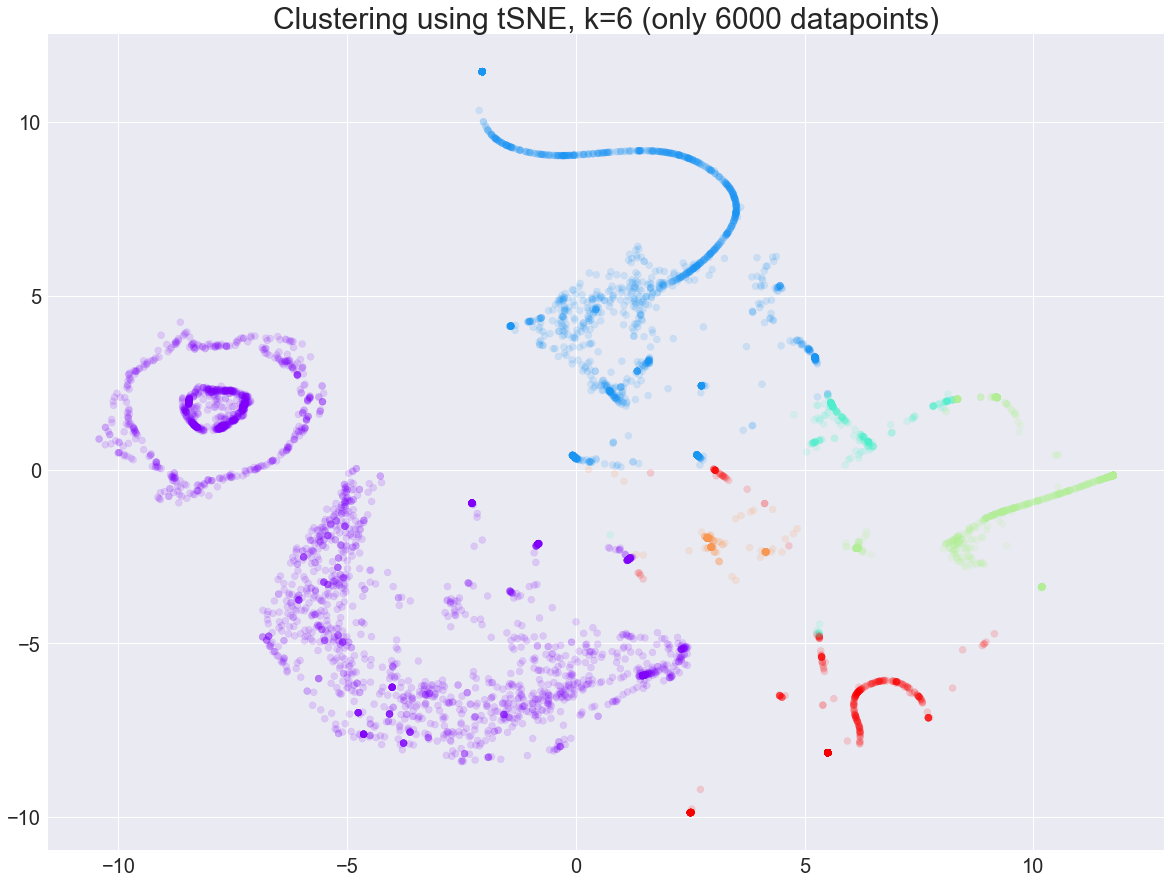

In [47]:
plt.figure(figsize=(20, 15))
plt.title('Clustering using tSNE, k=6 (only 6000 datapoints)',fontsize=30)
plt.scatter(X_ne[:, 0], X_ne[:, 1],alpha=0.15,c=clusts[400000:406000],cmap=plt.cm.rainbow)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('tSNE perplexity=200.png', bbox_inches='tight');

## Find my tweet

In [77]:
df_full_cluster[df_full_cluster['screen_name']=='miranda_zhao']

## mostly about the wedding, tiny bit of Royal Wedding

,location,screen_name,source,text,cleaned_text,0,1,2,3,4,time,cluster
223558,None,miranda_zhao,"<a href=""http://twitter.com/download/android"" ...",Watching the #RoyalWedding so I can see my own...,watching the #royalwedding so i can see my own...,1,0,0,0,0,2018-05-19 10:45:40,1


In [87]:
df_full_cluster[df_full_cluster['screen_name']=='miranda_zhao']['cleaned_text'].values

array(['watching the #royalwedding so i can see my own tweet in mongos database that i am live streaming sleepy #meghanmarkl'],
      dtype=object)

In [88]:
df_full_cluster[df_full_cluster['screen_name']=='bbcworldservice']

## mostly about wedding and the queen, and a little bit of Congratulations Meghan and Harry

,location,screen_name,source,text,cleaned_text,0,1,2,3,4,time,cluster
105452,None,bbcworldservice,"<a href=""http://www.socialflow.com"" rel=""nofol...",Ready for this? Here are the key timings for t...,ready for this here are the key timings for th...,1,0,0,0,0,2018-05-19 09:10:00,1
157770,None,bbcworldservice,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","Be honest, these are the only pictures you rea...",be honest these are the only pictures you real...,1,0,0,0,0,2018-05-19 09:51:59,1
230125,None,bbcworldservice,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",And the top trending wedding guest in the worl...,and the top trending wedding guest in the worl...,0,0,0,1,0,2018-05-19 10:50:58,1
242199,None,bbcworldservice,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",A very happy looking Prince Harry with his bro...,a very happy looking prince harry with his bro...,0,0,1,0,0,2018-05-19 10:59:37,2
532098,None,bbcworldservice,"<a href=""http://www.socialflow.com"" rel=""nofol...",If you really really still want more of the #R...,if you really really still want more of the #r...,1,0,0,0,0,2018-05-19 20:00:12,1
693442,None,bbcworldservice,"<a href=""http://www.socialflow.com"" rel=""nofol...","The Real Story, a royal story... why did so ma...",the real story a royal story why did so many e...,1,0,0,0,0,2018-05-20 08:03:09,1
708895,None,bbcworldservice,"<a href=""http://www.socialflow.com"" rel=""nofol...",Still want more? Download the best of our #Roy...,still want more download the best of our #roya...,1,0,0,0,0,2018-05-20 09:47:42,1
709562,None,bbcworldservice,"<a href=""http://www.socialflow.com"" rel=""nofol...",Still want more? Download the best of our #Roy...,still want more download the best of our #roya...,1,0,0,0,0,2018-05-20 09:52:43,1
763304,None,bbcworldservice,"<a href=""http://www.socialflow.com"" rel=""nofol...",A celebration of mixed-race identity as Meghan...,a celebration of mixedrace identity as meghan ...,0,0,1,0,0,2018-05-20 15:50:27,2


## Location Analysis on the Tweets

In [104]:
# Refer to Step 3_Location on the pickled dataframe
with open('locationdataframe.pkl','rb') as file:
    locationdf = pickle.load(file)

In [107]:
df_location = pd.merge(df_full_cluster, locationdf)

In [114]:
df_location.drop('created_at',axis=1,inplace=True)

In [115]:
df_location.head(5)

,screen_name,source,text,cleaned_text,0,1,2,3,4,time,cluster,loc,country
0,SueSpenceDaniel,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Royal Wedding countdown... can't wait! #RoyalW...,royal wedding countdown cant wait #royalwed,0,0,0,1,0,2018-05-18 23:32:39,4,midwest usa - blog:,usa
1,AsliAyan1,"<a href=""http://twitter.com/download/iphone"" r...",İngiliz kraliyetini yıllardır çok severek taki...,i̇ngiliz kraliyetini yıllardır çok severek tak...,0,0,0,0,1,2018-05-18 23:32:40,5,None,NaN
2,VictorMochere,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",DONATE:\n\nAs a football fan and an adventurer...,donateas a football fan and an adventurer it h...,0,0,0,0,1,2018-05-18 23:32:41,0,"nairobi, kenya",other
3,Nath_Maia,"<a href=""http://twitter.com/download/android"" ...",Só queria dizer que se eu casasse com o Princi...,só queria dizer que se eu casasse com o princi...,0,1,0,0,0,2018-05-18 23:32:41,3,curitiba,other
4,weemazsmith,"<a href=""http://twitter.com/download/android"" ...",What am I going to do ! My fav prince is getti...,what am i going to do my fav prince is gettin...,1,0,0,0,0,2018-05-18 23:32:44,1,lanarkshire sco,other


In [110]:
df_location.country.value_counts()

other    480731
usa      116241
uk       106492
Name: country, dtype: int64

In [116]:
df_location.to_pickle('location_analysis_df.pkl')

In [147]:
# For the US, define topics 
df_usa = df_location.loc[(df_location['country']=='usa'),['cluster','cleaned_text']]
df_usa.cluster.value_counts(normalize=True)

#wedding

1    0.340405
0    0.319362
3    0.173940
5    0.074303
2    0.056108
4    0.035882
Name: cluster, dtype: float64

In [149]:
# For the UK, define topics
df_uk = df_location.loc[(df_location['country']=='uk'),['cluster','cleaned_text']]
df_uk.cluster.value_counts(normalize=True)

#wedding 

1    0.374798
0    0.246892
3    0.199301
5    0.072935
2    0.055319
4    0.050755
Name: cluster, dtype: float64

In [150]:
# For the rest of the world, define topics
df_other = df_location.loc[(df_location['country']=='other'),['cluster','cleaned_text']]
df_other.cluster.value_counts(normalize=True)

# cluster 0 --> Royal Family & Congratulations Meghan & Harry

0    0.379720
1    0.285836
3    0.181846
5    0.085840
2    0.041541
4    0.025218
Name: cluster, dtype: float64

In [130]:
#Who talked about the sermon?
df_vector5 = df_location.loc[(df_location['cluster']==5),['country']]

In [131]:
df_vector5.country.value_counts()

other    41266
usa       8637
uk        7767
Name: country, dtype: int64

## Sentiment Analysis on tweets based on location

In [135]:
from textblob import TextBlob

In [186]:
# 0 is very objective, 1 is very subjective
TextBlob("i dislike datascience.").sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [180]:
polarity_usa = []
subjectivity_usa=[]
for i in df_usa['cleaned_text']:
    polarity_usa.append(TextBlob(i).sentiment[0])
    subjectivity_usa.append(TextBlob(i).sentiment[1])

print(np.mean(polarity_usa))
print(np.mean(subjectivity_usa))

0.15118641360437174
0.34692687388797105


In [181]:
polarity_uk = []
subjectivity_uk=[]
for i in df_uk['cleaned_text']:
    polarity_uk.append(TextBlob(i).sentiment[0])
    subjectivity_uk.append(TextBlob(i).sentiment[1])

print(np.mean(polarity_uk))
print(np.mean(subjectivity_uk))

0.17536929868471113
0.37752602577465905


In [182]:
polarity_other = []
subjectivity_other=[]
for i in df_other['cleaned_text']:
    polarity_other.append(TextBlob(i).sentiment[0])
    subjectivity_other.append(TextBlob(i).sentiment[1])

print(np.mean(polarity_other))
print(np.mean(subjectivity_other))

0.10557816002783182
0.24237132212871232
